In [ ]:
import pandas as pd

datos = pd.read_csv('Datos/clasificador_diabetes_ml_csv_v2.0.0__diabetes_clasificacion_prediction_dataset.csv')
datos.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


### EDA

In [2]:
datos.info()

<class 'pandas.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  str    
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  str    
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), str(2)
memory usage: 6.9 MB


In [3]:
datos.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


Nota: Revisar blood_glucose_level porque puede tener **outliners**

In [4]:
datos.duplicated().sum()

np.int64(3854)

Nota: Eliminar datos duplicados

In [2]:
datos = datos.drop_duplicates()
datos.duplicated().sum() #Verificamos que ya no hayan duplicados

np.int64(0)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='diabetes', data=datos)
plt.title('Distribución de la variable objetivo')
plt.xlabel('Diabetes')
plt.ylabel('Cantidad de casos')
plt.show()

In [7]:
datos.diabetes.value_counts()

diabetes
0    87664
1     8482
Name: count, dtype: int64

In [10]:
datos.gender.value_counts()

gender
Female    56161
Male      39967
Other        18
Name: count, dtype: int64

Nota: La diabetes es la variable objetivo que se predice, con valores de 1 que indican la presencia de diabetes y 0 que indican. Por lo tanto, la variable objetivo esta desbalanceada con mas casos sin diabetes ("0")

In [ ]:
datos.smoking_history.value_counts()

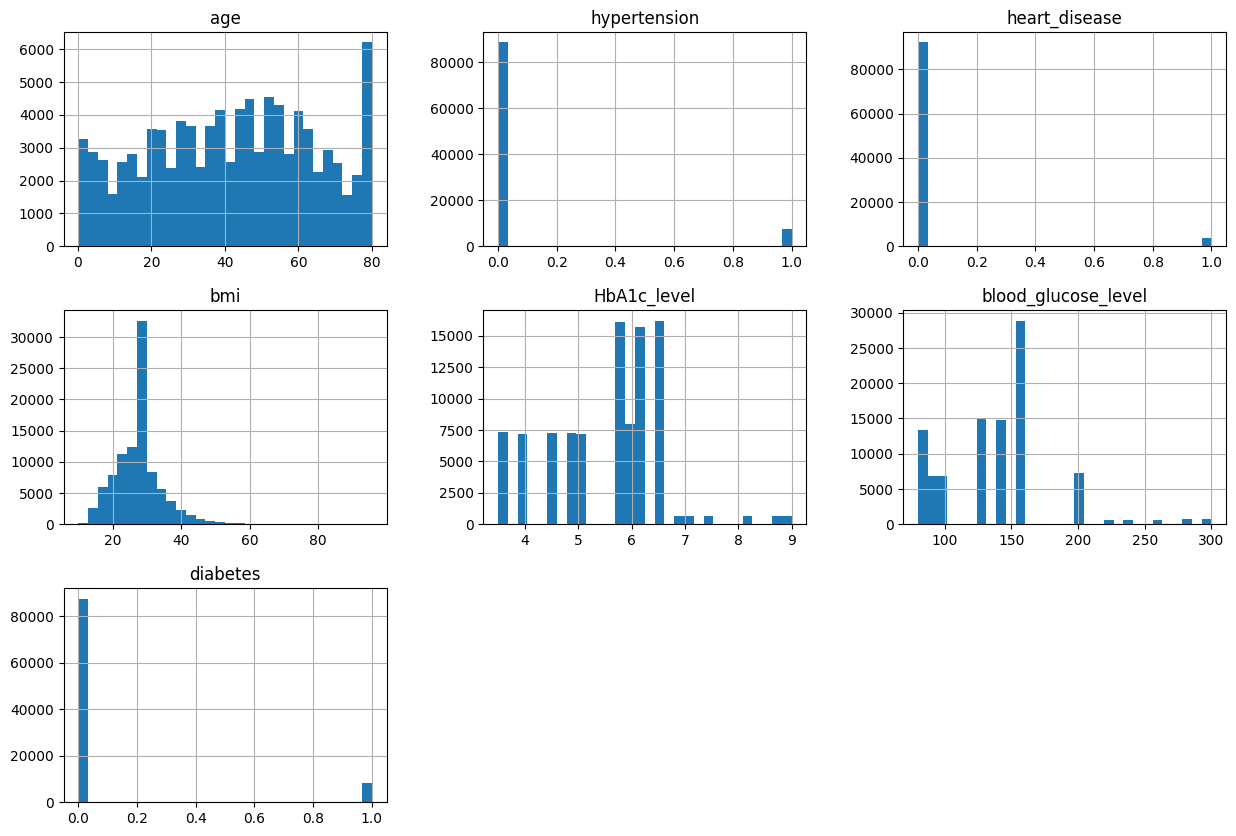

In [ ]:
datos.hist(bins=30, figsize=(15,10))
plt.show()

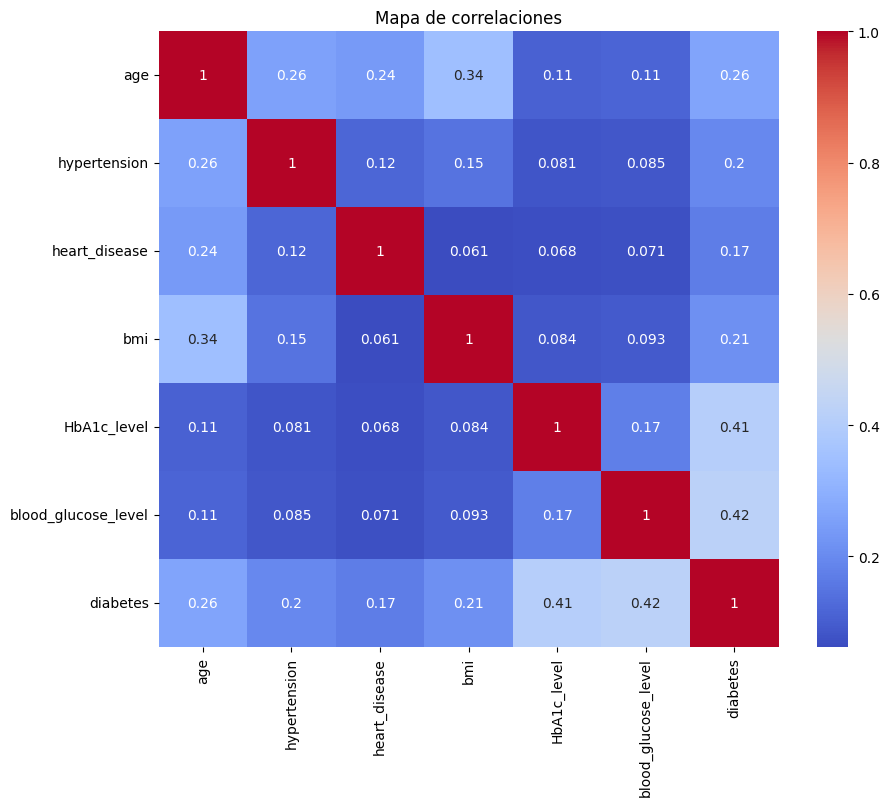

In [ ]:
datos_correlation = datos.select_dtypes(include=['int64', 'float64']).corr()

plt.figure(figsize=(10,8)) 
sns.heatmap(datos_correlation, annot=True, cmap="coolwarm") 
plt.title("Mapa de correlaciones") 
plt.show()

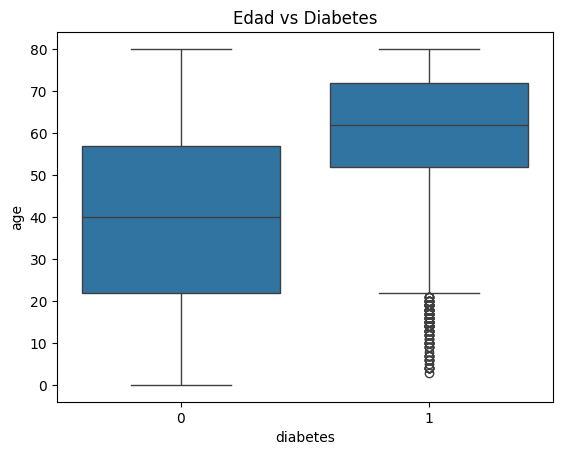

In [ ]:
sns.boxplot(x="diabetes", y="age", data=datos)
plt.title("Edad vs Diabetes")
plt.show()

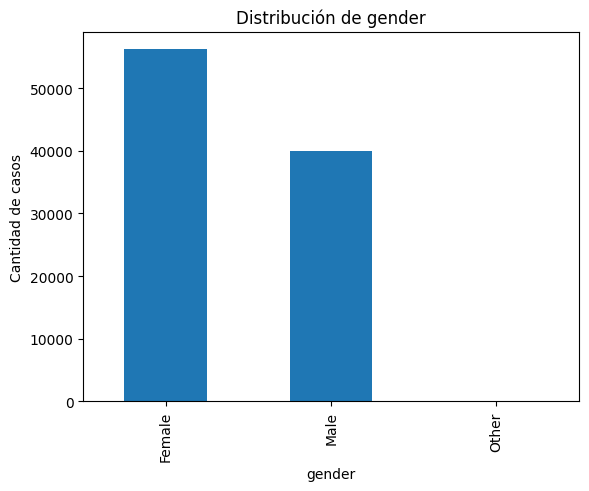

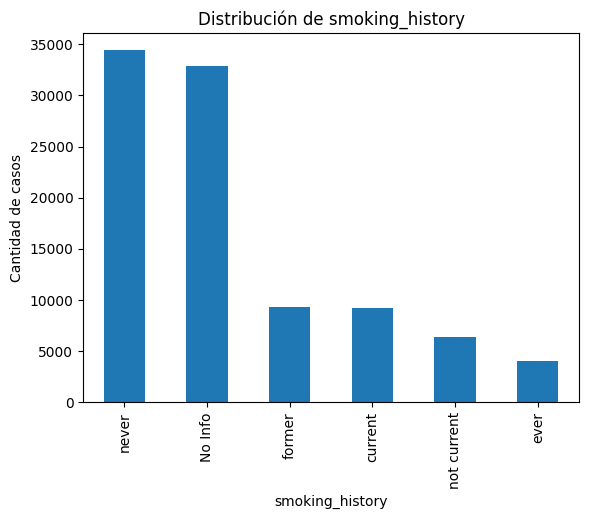

In [ ]:
#Columnas categoricas
col_cat = datos.select_dtypes(include=['str']).columns
for col in col_cat:
    datos[col].value_counts().plot(kind='bar')
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Cantidad de casos')
    plt.show()

### Division de Datos en Entrenamiento y Prueba

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV

X = datos.drop("diabetes", axis=1).values
y = datos.diabetes.values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [ ]:
#Creacion del preprocesamiento
#Columnas numericas se usara StandardScaler como primera instancia
#Columnas categoricas se usara OneHotEncoder como primera instancia
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from imblearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
#Balanceo del dataset con SMOTE
from imblearn.over_sampling import SMOTE

preprocesamiento = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), [1, 5, 6]),
        ("cat", OneHotEncoder(handle_unknown="ignore"), [0, 4])
    ],
    remainder="passthrough"
)


pipe = Pipeline(
    steps=[
        ("preprocessing", preprocesamiento),
        ("smote", SMOTE(random_state=42)),
        ("modelo", MLPClassifier(max_iter=500, random_state=42))
    ]
)

### Definir parámetros para GridSearchCV

In [ ]:
param_grid = {
    "modelo__hidden_layer_sizes": [100,200],
    "modelo__activation": ["logistic"],
    "modelo__learning_rate_init": [0.001, 0.01],
    "modelo__early_stopping": [True, False]}
param_grid_nuevo = {
    "modelo__hidden_layer_sizes": [100, 200],
    "modelo__activation": ["logistic"],
    "modelo__learning_rate_init": [0.001]}

### Ejecutar GridSearchCV

In [ ]:
grid_search = GridSearchCV(pipe, param_grid_nuevo, cv=5, n_jobs=-1,scoring="f1")

grid_search.fit(X_train, y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'modelo__activation': ['logistic'], 'modelo__hidden_layer_sizes': [100, 200], 'modelo__learning_rate_init': [0.001]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'f1'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candi

In [ ]:
#Imprimir los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid_search.best_params_)


Mejores hiperparámetros: {'modelo__activation': 'logistic', 'modelo__hidden_layer_sizes': 100, 'modelo__learning_rate_init': 0.001}


In [ ]:
#Estos fueron los mejores hiperparámetros encontrados en la version 1.0.0: 
# {'modelo__activation': 'logistic', 
# 'modelo__early_stopping': False, 
# 'modelo__hidden_layer_sizes': 200, 
# 'modelo__learning_rate_init': 0.01}

#Usaremos SMOTE para balancear el dataset
#Mejores hiperparámetros: {'modelo__activation': 'logistic', 
#'modelo__early_stopping': False, 
#'modelo__hidden_layer_sizes': 100, 
#'modelo__learning_rate_init': 0.001}

#Evaluacion usando param_grid_nuevo y scoring="f1"
#Mejores hiperparámetros: {'modelo__activation': 'logistic', 
#'modelo__hidden_layer_sizes': 100, 
#'modelo__learning_rate_init': 0.001}

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

#Evaluacion del modelo con los datos de prueba
predictions = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions, average="macro")
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.99      0.92      0.95     26267
           1       0.51      0.87      0.64      2577

    accuracy                           0.91     28844
   macro avg       0.75      0.89      0.80     28844
weighted avg       0.94      0.91      0.92     28844



In [ ]:
#Resultados sin balancear el dataset:
#   precision    recall  f1-score   support

#           0       0.97      1.00      0.98     26267
#           1       0.99      0.68      0.81      2577

#    accuracy                           0.97     28844
#   macro avg       0.98      0.84      0.90     28844
#weighted avg       0.97      0.97      0.97     28844

#Resultados con balanceo del dataset:
#              precision    recall  f1-score   support

#           0       0.99      0.92      0.95     26267
#           1       0.51      0.87      0.64      2577

#    accuracy                           0.91     28844
#   macro avg       0.75      0.89      0.80     28844
#weighted avg       0.94      0.91      0.92     28844

#Resultados con balanceo del dataset y usando param_grid_nuevo, ademas de usar scoring="f1 en el GridSearchCV:
#               precision    recall  f1-score   support

#           0       0.99      0.92      0.95     26267
#           1       0.51      0.87      0.64      2577

#    accuracy                           0.91     28844
#   macro avg       0.75      0.89      0.80     28844
#weighted avg       0.94      0.91      0.92     28844

In [ ]:
from sklearn.metrics import roc_curve
fpr, rpr, thresholds = roc_curve(y_test, grid_search.predict_proba(X_test)[:, 1])
plt.figure(figsize=(8,6))
plt.plot(fpr, rpr, color='darkorange', label="ROC Curve")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()